# Scalable Diffusion Models with Transformer (DiT)

This notebook samples from pre-trained DiT models. DiTs are class-conditional latent diffusion models trained on ImageNet that use transformers in place of U-Nets as the DDPM backbone. DiT outperforms all prior diffusion models on the ImageNet benchmarks.

[Project Page](https://www.wpeebles.com/DiT) | [HuggingFace Space](https://huggingface.co/spaces/wpeebles/DiT) | [Paper](http://arxiv.org/abs/2212.09748) | [GitHub](github.com/facebookresearch/DiT)

# 1. Setup

We recommend using GPUs (Runtime > Change runtime type > Hardware accelerator > GPU). Run this cell to clone the DiT GitHub repo and setup PyTorch. You only have to run this once.

In [ ]:
!git clone https://github.com/facebookresearch/DiT.git
import DiT, os
os.chdir('DiT')
os.environ['PYTHONPATH'] = '/env/python:/content/DiT'
!pip install diffusers timm --upgrade

In [1]:
# DiT imports:
import torch
from torchvision.utils import save_image
from diffusion import create_diffusion
from diffusers.models import AutoencoderKL
from download import find_model
from models import DiT_XL_2
from PIL import Image
from IPython.display import display
from modelscope import snapshot_download
torch.set_grad_enabled(False)
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("GPU not found. Using CPU instead.")

正克隆到 'DiT'...
remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 102 (delta 55), reused 35 (delta 35), pack-reused 24
接收对象中: 100% (102/102), 6.37 MiB | 4.06 MiB/s, 完成.
处理 delta 中: 100% (56/56), 完成.
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
DEPRECATION: pytorch-lightning 1.7.7 has a non-standard dependency specifier torch>=1.9.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-02-21 10:56:06,878 - modelscope - INFO - PyTorch version 2.1.2+cu121 Found.
2024-02-21 10:56:06,880 - modelscope - INFO - TensorFlow version 2.14.0 Found.
2024-02-21 10:56:06,881 - modelscope - INFO - Loading ast index from /mnt/workspace/.cache/modelscope/ast_indexer
2024-02-21 10:56:06,907 - modelscope - INFO - Loading done! Current index file version is 1.12.0, with md5 509123dba36c5e70a95f6780df348471 and a total number of 964 components indexed


# Download DiT-XL/2 Models

You can choose between a 512x512 model and a 256x256 model. You can swap-out the LDM VAE, too.

In [3]:
image_size = 256 #@param [256, 512]
vae_model = snapshot_download("AI-ModelScope/sd-vae-ft-ema") #@param ["stabilityai/sd-vae-ft-mse", "stabilityai/sd-vae-ft-ema"]
latent_size = int(image_size) // 8
# Load model:
model = DiT_XL_2(input_size=latent_size).to(device)
DiT_model = snapshot_download(f"AI-ModelScope/DiT-XL-2-{image_size}x{image_size}")
state_dict = find_model(f"{DiT_model}/DiT-XL-2-{image_size}x{image_size}.pt")
model.load_state_dict(state_dict)
model.eval() # important!
vae = AutoencoderKL.from_pretrained(vae_model).to(device)

# 2. Sample from Pre-trained DiT Models

You can customize several sampling options. For the full list of ImageNet classes, [check out this](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).

100%|██████████| 250/250 [01:49<00:00,  2.29it/s]


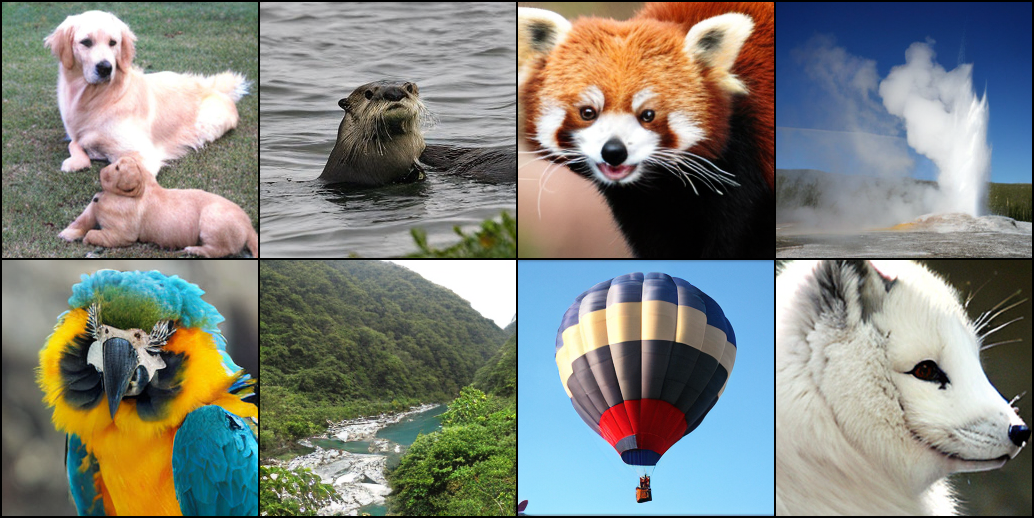

In [4]:
# Set user inputs:
seed = 0 #@param {type:"number"}
torch.manual_seed(seed)
num_sampling_steps = 250 #@param {type:"slider", min:0, max:1000, step:1}
cfg_scale = 4 #@param {type:"slider", min:1, max:10, step:0.1}
class_labels = 207, 360, 387, 974, 88, 979, 417, 279 #@param {type:"raw"}
samples_per_row = 4 #@param {type:"number"}

# Create diffusion object:
diffusion = create_diffusion(str(num_sampling_steps))

# Create sampling noise:
n = len(class_labels)
z = torch.randn(n, 4, latent_size, latent_size, device=device)
y = torch.tensor(class_labels, device=device)

# Setup classifier-free guidance:
z = torch.cat([z, z], 0)
y_null = torch.tensor([1000] * n, device=device)
y = torch.cat([y, y_null], 0)
model_kwargs = dict(y=y, cfg_scale=cfg_scale)

# Sample images:
samples = diffusion.p_sample_loop(
    model.forward_with_cfg, z.shape, z, clip_denoised=False, 
    model_kwargs=model_kwargs, progress=True, device=device
)
samples, _ = samples.chunk(2, dim=0)  # Remove null class samples
samples = vae.decode(samples / 0.18215).sample

# Save and display images:
save_image(samples, "sample.png", nrow=int(samples_per_row), 
           normalize=True, value_range=(-1, 1))
samples = Image.open("sample.png")
display(samples)